# CenterNet


In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from ROI.neural_network import *
from training import initialize_weights

## Prepare dataset for training CenterNet

- Crop black edges from high resolution images
- Pad images and masks to square shape
- Save resulting files to separate directories
- Generate ground truth bounding boxes
- Create CSV file with image and mask paths and bounding boxes


In [ ]:
generate_centernet_dataset(
    src_image_paths='../data/ORIGA/TrainImages',
    dst_images_dir='../data/ORIGA/CenterNet/TrainImages',
    src_mask_paths='../data/ORIGA/TrainMasks',
    dst_masks_dir='../data/ORIGA/CenterNet/TrainMasks',
)

generate_centernet_dataset(
    src_image_paths='../data/ORIGA/TestImages',
    dst_images_dir='../data/ORIGA/CenterNet/TestImages',
    src_mask_paths='../data/ORIGA/TestMasks',
    dst_masks_dir='../data/ORIGA/CenterNet/TestMasks',
)

generate_centernet_dataset(
    src_image_paths='../data/DRISHTI/TrainImages',
    dst_images_dir='../data/DRISHTI/CenterNet/TrainImages',
    src_mask_paths='../data/DRISHTI/TrainMasks',
    dst_masks_dir='../data/DRISHTI/CenterNet/TrainMasks',
    otsu_crop=False,
)

generate_centernet_dataset(
    src_image_paths='../data/DRISHTI/TestImages',
    dst_images_dir='../data/DRISHTI/CenterNet/TestImages',
    src_mask_paths='../data/DRISHTI/TestMasks',
    dst_masks_dir='../data/DRISHTI/CenterNet/TestMasks',
    otsu_crop=False,
)

generate_centernet_dataset(
    src_image_paths='../data/RIMONE/TrainImages',
    dst_images_dir='../data/RIMONE/CenterNet/TrainImages',
    src_mask_paths='../data/RIMONE/TrainMasks',
    dst_masks_dir='../data/RIMONE/CenterNet/TrainMasks',
    otsu_crop=False,
)

generate_centernet_dataset(
    src_image_paths='../data/RIMONE/TestImages',
    dst_images_dir='../data/RIMONE/CenterNet/TestImages',
    src_mask_paths='../data/RIMONE/TestMasks',
    dst_masks_dir='../data/RIMONE/CenterNet/TestMasks',
    otsu_crop=False,
)

In [2]:
csf_file = r'../data/CenterNetGroundTruthBoundingBoxes.csv'

if not os.path.exists(csf_file):
    df = generate_ground_truth_bbox_csv(
        images_dir=[
            '../data/ORIGA/CenterNet/TrainImages', '../data/ORIGA/CenterNet/TestImages',
            '../data/DRISHTI/CenterNet/TrainImages', '../data/DRISHTI/CenterNet/TestImages',
            '../data/RIMONE/CenterNet/TrainImages', '../data/RIMONE/CenterNet/TestImages',
        ],
        masks_dir=[
            '../data/ORIGA/CenterNet/TrainMasks', '../data/ORIGA/CenterNet/TestMasks',
            '../data/DRISHTI/CenterNet/TrainMasks', '../data/DRISHTI/CenterNet/TestMasks',
            '../data/RIMONE/CenterNet/TrainMasks', '../data/RIMONE/CenterNet/TestMasks',
        ],
        csv_file=csf_file,
        margin=16,
    )
else:
    df = pd.read_csv(csf_file)

train_df, val_df = train_test_split(df, test_size=0.05, random_state=48)
print('Training size:', len(train_df))
print('Validation size:', len(val_df))
df.head(10)

Training size: 864
Validation size: 46


,image_id,mask_id,x,y,w,h
0,..\data\ORIGA\CenterNet\TrainImages\001.jpg,..\data\ORIGA\CenterNet\TrainMasks\001.png,1335.0,1031.0,411.0,497.0
1,..\data\ORIGA\CenterNet\TrainImages\002.jpg,..\data\ORIGA\CenterNet\TrainMasks\002.png,843.0,872.0,385.0,475.0
2,..\data\ORIGA\CenterNet\TrainImages\003.jpg,..\data\ORIGA\CenterNet\TrainMasks\003.png,759.0,955.0,422.0,436.0
3,..\data\ORIGA\CenterNet\TrainImages\004.jpg,..\data\ORIGA\CenterNet\TrainMasks\004.png,1460.0,1060.0,360.0,406.0
4,..\data\ORIGA\CenterNet\TrainImages\005.jpg,..\data\ORIGA\CenterNet\TrainMasks\005.png,741.0,1026.0,407.0,423.0
5,..\data\ORIGA\CenterNet\TrainImages\007.jpg,..\data\ORIGA\CenterNet\TrainMasks\007.png,720.0,972.0,378.0,405.0
6,..\data\ORIGA\CenterNet\TrainImages\011.jpg,..\data\ORIGA\CenterNet\TrainMasks\011.png,1331.0,1015.0,369.0,371.0
7,..\data\ORIGA\CenterNet\TrainImages\014.jpg,..\data\ORIGA\CenterNet\TrainMasks\014.png,744.0,1033.0,312.0,394.0
8,..\data\ORIGA\CenterNet\TrainImages\015.jpg,..\data\ORIGA\CenterNet\TrainMasks\015.png,837.0,865.0,368.0,426.0
9,..\data\ORIGA\CenterNet\TrainImages\016.jpg,..\data\ORIGA\CenterNet\TrainMasks\016.png,736.0,1077.0,360.0,375.0


## Model & dataset configuration

- Split dataset into training and validation sets
- Set hyper-parameters
- Data augmentation
- Create datasets and dataloaders


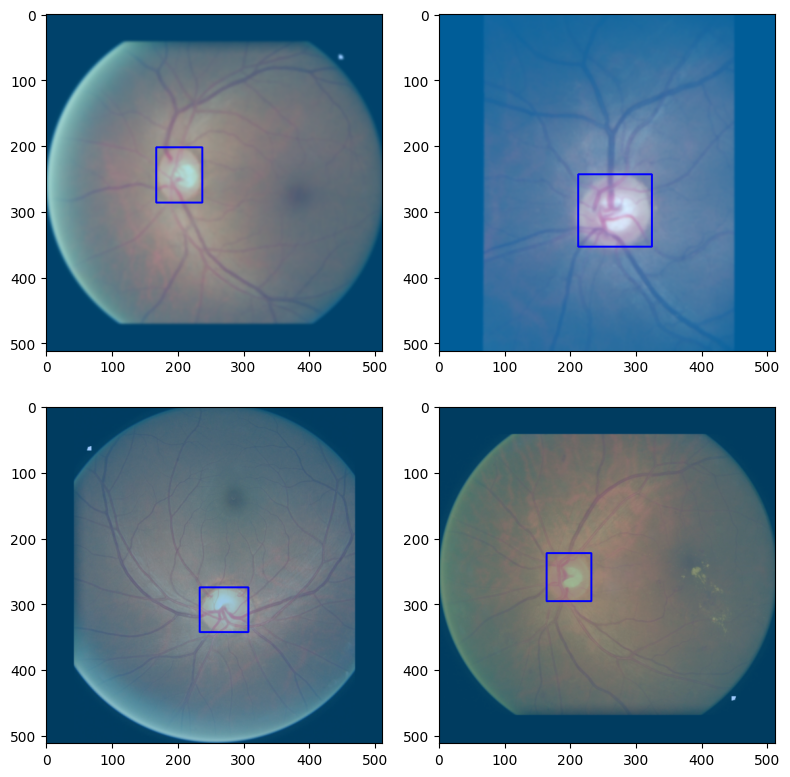

In [4]:
INPUT_SIZE = 512
MODEL_SCALE = 4
BATCH_SIZE = 8

train_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.GaussianBlur(p=0.5, blur_limit=(5, 15)),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

res = []
dataset = CenterNetDataset(df, INPUT_SIZE, MODEL_SCALE, train_transform)
for i in range(4):
    index = np.random.randint(0, len(dataset))
    img, heatmap, regression, bboxes, *_ = dataset[index]
    img -= img.min()
    img /= img.max()
    img = img.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    for bbox in bboxes:
        x, y, w, h = [int(v) for v in bbox]
        img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    res.append(img)
_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, img in enumerate(res):
    ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [5]:
train_dataset = CenterNetDataset(train_df, INPUT_SIZE, MODEL_SCALE, train_transform)
val_dataset = CenterNetDataset(val_df, INPUT_SIZE, MODEL_SCALE, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Train model

- Initialize model, optimizer, loss function and scheduler
- Train model
- Plot training history
- Save model


In [6]:
MODEL_PATH = r'../models/ROI/centernet.pth'
LEARNING_RATE = 1e-4
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
SCHEDULER_PATIENCE = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CenterNet(n_classes=1, scale=MODEL_SCALE, base='resnet18', custom=True)
if MODEL_PATH:
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    print('Model loaded from', MODEL_PATH)
else:
    initialize_weights(model)
model = model.to(DEVICE)

criterion = CenterLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=SCHEDULER_PATIENCE, verbose=True)

Model loaded from ../models/ROI/centernet.pth


In [ ]:
hist, best_weights = fit(
    model, optimizer, criterion, DEVICE, train_loader, val_loader,
    epochs=EPOCHS, scheduler=scheduler, early_stopping_patience=EARLY_STOPPING_PATIENCE,
)

torch.save(model.state_dict(), 'centernet.pth')
torch.save(best_weights, 'best_centernet.pth')

for k, v in hist.items():
    print(f'{k}: {v[-1]}')

In [ ]:
avg_loss = np.mean(hist['train_loss']) + np.mean(hist['val_loss'])

plt.figure(figsize=(8, 8))
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.ylim(0, avg_loss * 2)
plt.legend()
plt.show()

## Create cropped RoI dataset

- Detect square regions of interest in all images
- Generate cropped RoI dataset for segmentation models


In [7]:
image_names = sorted(df['image_id'].unique())
mask_names = sorted(df['mask_id'].unique())

In [ ]:
origa_train_images = list(filter(lambda x: 'ORIGA' in x and 'TrainImages' in x, image_names))
origa_train_masks = list(filter(lambda x: 'ORIGA' in x and 'TrainMasks' in x, mask_names))

generate_roi_dataset(
    model, origa_train_images, origa_train_masks, '../data/ORIGA/ROI/TrainImages', '../data/ORIGA/ROI/TrainMasks',
    val_transform, INPUT_SIZE, DEVICE, small_margin=32, large_margin=0, roi_size=512,
)

In [ ]:
origa_test_images = list(filter(lambda x: 'ORIGA' in x and 'TestImages' in x, image_names))
origa_test_masks = list(filter(lambda x: 'ORIGA' in x and 'TestMasks' in x, mask_names))

generate_roi_dataset(
    model, origa_test_images, origa_test_masks, '../data/ORIGA/ROI/TestImages', '../data/ORIGA/ROI/TestMasks',
    val_transform, INPUT_SIZE, DEVICE, small_margin=32, large_margin=0, roi_size=512,
)

In [ ]:
drishti_train_images = list(filter(lambda x: 'DRISHTI' in x and 'TrainImages' in x, image_names))
drishti_train_masks = list(filter(lambda x: 'DRISHTI' in x and 'TrainMasks' in x, mask_names))

generate_roi_dataset(
    model, drishti_train_images, drishti_train_masks, '../data/DRISHTI/ROI/TrainImages', '../data/DRISHTI/ROI/TrainMasks',
    val_transform, INPUT_SIZE, DEVICE, small_margin=32, large_margin=0, roi_size=512,
)

In [ ]:
drishti_test_images = list(filter(lambda x: 'DRISHTI' in x and 'TestImages' in x, image_names))
drishti_test_masks = list(filter(lambda x: 'DRISHTI' in x and 'TestMasks' in x, mask_names))

generate_roi_dataset(
    model, drishti_test_images, drishti_test_masks, '../data/DRISHTI/ROI/TestImages', '../data/DRISHTI/ROI/TestMasks',
    val_transform, INPUT_SIZE, DEVICE, small_margin=32, large_margin=0, roi_size=512,
)

## Make predictions

- Load new image
- Predict bounding boxes


In [ ]:
generate_centernet_dataset(
    src_image_paths='../data/ImagesForSegmentation/',
    dst_images_dir='../data/ImagesForSegmentation/CenterNet',
)

image_names = sorted(os.listdir('../data/ImagesForSegmentation/CenterNet'))

generate_roi_dataset(
    model, image_names, None, '../data/ImagesForSegmentation/ROI', None,
    val_transform, INPUT_SIZE, DEVICE, small_margin=32, large_margin=0, roi_size=512,
)

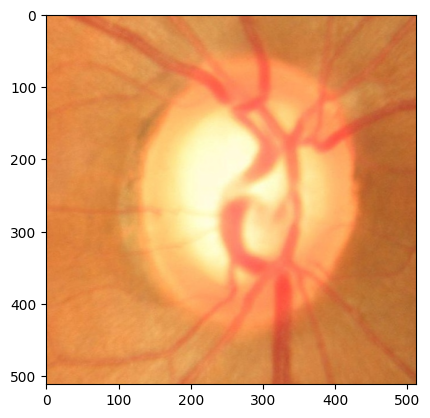

In [12]:
new_file = "../data/ORIGA/TrainImages/001.jpg"

preprocessed_img, _ = preprocess_centernet_input(new_file)
roi_image, _ = detect_roi(
    model, preprocessed_img, None, val_transform, INPUT_SIZE,
    device=DEVICE, small_margin=16, roi_size=512,
)

plt.imshow(roi_image)
plt.show()